In [2]:
# uncomment when needed:
# !pip install openpyxl
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.core.interchange.dataframe_protocol import DataFrame

# Sets the path to the parent directory of RR classes

project_root = os.path.dirname(os.path.abspath("Code assignment in Python.ipynb"))  # Get the script's directory
os.chdir(project_root) # Set working directory
csv_path = os.path.join(project_root, "..", "Data", "onet_tasks.csv")
excel_path = os.path.join(project_root, "..", "Data", "Eurostat_employment_isco.xlsx")
number_of_categories = 9
countries = ["Belgium", "Poland", "Spain"]
tasks1=["Belgium_NRCA","Poland_NRCA","Spain_NRCA"]
# Import data from the O*NET database, at ISCO-08 occupation level.
# The original data uses a version of SOC classification, but the data we load here
# are already cross-walked to ISCO-08 using: https://ibs.org.pl/en/resources/occupation-classifications-crosswalks-from-onet-soc-to-isco/

# The O*NET database contains information for occupations in the USA, including
# the tasks and activities typically associated with a specific occupation.
try:
    task_data = pd.read_csv(csv_path)
except FileNotFoundError:
    print("Wrong path for onet_tasks.csv")

# isco08 variable is for occupation codes
# the t_* variables are specific tasks conducted on the job
# read employment data from Eurostat
# These datasets include quarterly information on the number of workers in specific
# 1-digit ISCO occupation categories. (Check here for details: https://www.ilo.org/public/english/bureau/stat/isco/isco08/)
isco_categories = {}
try:
    for i in range(1, number_of_categories):
        isco_categories[f"isco{i}"] = pd.read_excel(excel_path,
        sheet_name = f"ISCO{i}")
except FileNotFoundError:
    print("Wrong path for Eurostat_employment_isco.xlsx")

# This will calculate worker totals in each of the chosen countries.
def calculate_worker_totals(country: str):
    return sum(df[country] for df in isco_categories.values() if country in df.columns)

totals = {}
# Example usage for Belgium, Spain, and Poland
for country in countries:
    totals[country] = calculate_worker_totals(country)
    print(f"Total workers in {country}: {totals[country]}")

Total workers in Belgium: 0     3957.6
1     4029.7
2     3961.0
3     4009.8
4     3965.9
5     3974.6
6     4017.2
7     4032.2
8     3985.1
9     4005.2
10    4032.9
11    3982.4
12    3993.4
13    4028.0
14    3993.8
15    4026.8
16    4009.9
17    3977.4
18    3996.8
19    4002.0
20    3961.0
21    3981.6
22    4059.6
23    4112.1
24    4065.3
25    4088.9
26    4114.9
27    4190.8
28    4188.5
29    4176.9
30    4245.8
31    4276.9
32    4236.5
33    4310.9
34    4294.6
35    4266.1
36    4293.6
37    4255.1
38    4305.0
39    4275.8
Name: Belgium, dtype: float64
Total workers in Poland: 0     13997.9
1     14148.8
2     14230.3
3     14204.0
4     14022.3
5     14172.2
6     14251.0
7     14178.4
8     13920.4
9     14114.6
10    14293.2
11    14273.0
12    14178.5
13    14325.3
14    14520.9
15    14522.1
16    14372.9
17    14521.4
18    14726.0
19    14760.1
20    14527.8
21    14650.3
22    14776.0
23    14857.5
24    14762.4
25    14893.2
26    14892.2
27    14885.6
28    1

In [3]:
concat_data = []
# Let's merge all these datasets. We'll need a column that stores the occupation categories:
for i in range(1, number_of_categories):
    isco_categories[f"isco{i}"]['ISCO'] = i
    concat_data.append(isco_categories[f"isco{i}"])
    # print(isco_categories[f"isco{i}"])

# # and this gives us one large file with employment in all occupations.
all_data = pd.concat(concat_data, ignore_index=True)

# And this will give us shares of each occupation among all workers in a period-country
# We have 9 occupations and the same time range for each, so we can add the totals by
# adding a vector that is 9 times the previously calculated totals
for country in countries:
    all_data[f"total_{country}"] = pd.concat([totals[country]] * 9, ignore_index=True)
    all_data[f'share_{country}'] = all_data['Belgium'] / all_data[f"total_{country}"]
#

print(all_data)

        TIME European Union - 28 countries (2013-2020)  Belgium  Czechia  \
0    2011-Q1                                   12850.9    279.0    223.5   
1    2011-Q2                                   12834.2    304.7    226.2   
2    2011-Q3                                   12763.1    348.8    227.3   
3    2011-Q4                                   12668.1    347.9    230.3   
4    2012-Q1                                   12197.3    304.0    231.1   
..       ...                                       ...      ...      ...   
315  2019-Q4                                   16592.8    299.3    721.6   
316  2020-Q1                                         :    283.3    697.5   
317  2020-Q2                                         :    288.9    683.4   
318  2020-Q3                                         :    290.7    695.9   
319  2020-Q4                                         :    285.0    699.6   

     Denmark   Spain   Italy  Lithuania  Poland  Finland  Sweden  ISCO  \
0       57.6 

In [4]:
# Now let's look at the task data. We want the first digit of the ISCO variable only
import re

task_data["isco08_1dig"] = task_data["isco08"].astype(str).str[:1].astype(int)

# And we'll calculate the mean task values at a 1-digit level 
# (more on what these tasks are below)
aggdata = task_data.groupby(["isco08_1dig"]).mean()
aggdata = aggdata.drop(columns=["isco08"])

# We'll be interested in tracking the intensity of Non-routine cognitive analytical tasks
# Using a framework reminiscent of the work by David Autor.

#These are the ones we're interested in:
# Non-routine cognitive analytical
# 4.A.2.a.4 Analyzing Data or Information
# 4.A.2.b.2 Thinking Creatively
# 4.A.4.a.1 Interpreting the Meaning of Information for Others

#Let's combine the data.
combined = pd.merge(all_data, aggdata, left_on='ISCO', right_on='isco08_1dig', how='left')
# Traditionally, the first step is to standardise the task values using weights 
# defined by share of occupations in the labour force. This should be done separately
# for each country. Standardisation -> getting the mean to 0 and std. dev. to 1.
# Let's do this for each of the variables that interests us:



In [5]:
from scipy.stats import gmean

# Define tasks and countries
tasks = ["t_4A2a4", "t_4A2b2", "t_4A4a1"]


def standardize_tasks(tasks:list, countries:list,):
    # Loop through tasks and countries
    for task in tasks:
        for country in countries:
            weights = combined[f"share_{country}"]
            values = combined[task]

            weighted_mean = np.average(values, weights=weights)
            weighted_sd = np.sqrt(np.average((values - weighted_mean) ** 2, weights=weights))

            if task.split("_")[0] not in countries:
              combined[f"{country}_NRCA"] = (values - weighted_mean) / weighted_sd
              # combined[f"std_{country}_{task}"] = (values - weighted_mean) / weighted_sd
            else:
                combined[f"std_{task}"] = (values - weighted_mean) / weighted_sd
standardize_tasks(tasks, countries)

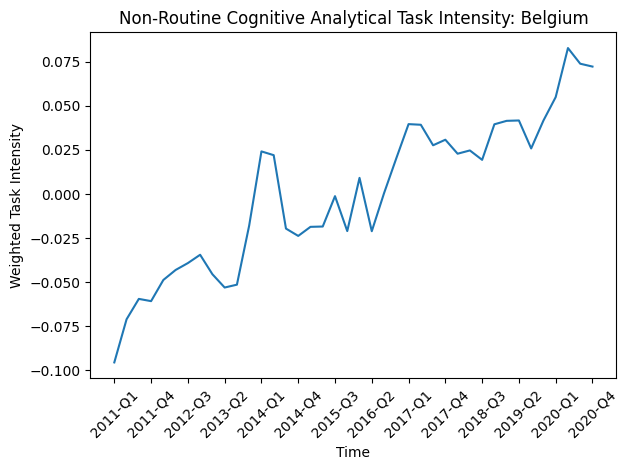

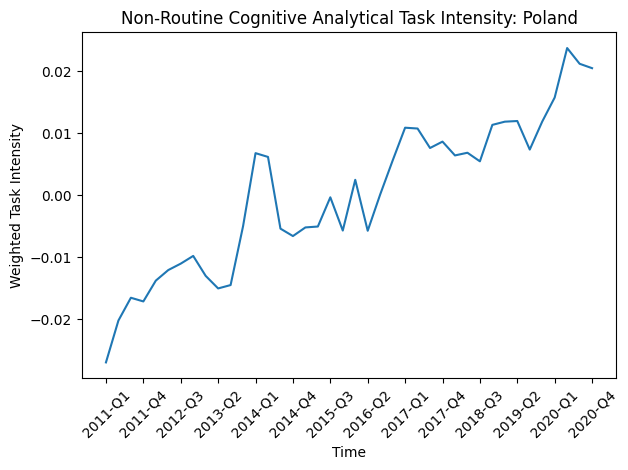

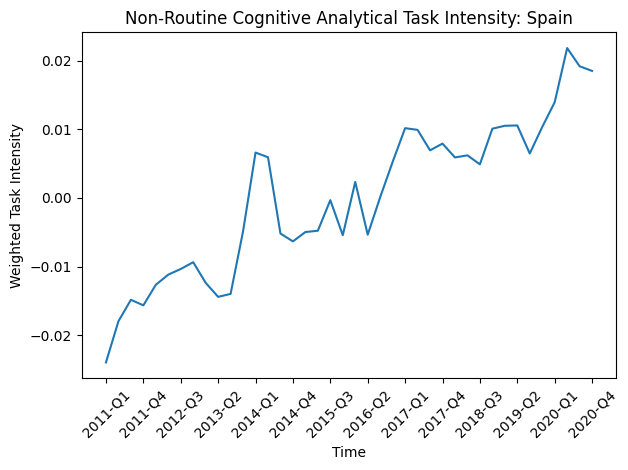

In [6]:
# The next step is to calculate the `classic` task content intensity, i.e.
# how important is a particular general task content category in the workforce
# Here, we're looking at non-routine cognitive analytical tasks, as defined
# by David Autor and Darron Acemoglu:


# And we standardise NRCA in a similar way.
standardize_tasks(tasks1, countries)

# Finally, to track the changes over time, we have to calculate a country-level mean
# Step 1: multiply the value by the share of such workers.

for country in countries:
    combined[f"multip_{country}_NRCA"] = combined[f"std_{country}_NRCA"] * combined[f"share_{country}"]

# Step 2: sum it up (it basically becomes another weighted mean)
agg_by_country = {}
for country in countries:
    agg = combined.groupby("TIME")[f"multip_{country}_NRCA"].sum().reset_index()
    agg_by_country[country] = agg

# We can plot it now!
for country in countries:
    agg = agg_by_country[country]
    plt.plot(agg["TIME"], agg[f"multip_{country}_NRCA"], label=country)

    # Optional: adjust x-ticks for readability
    plt.xticks(range(0, len(agg), 3), agg["TIME"][::3], rotation=45)

    plt.title(f"Non-Routine Cognitive Analytical Task Intensity: {country}")
    plt.xlabel("Time")
    plt.ylabel("Weighted Task Intensity")
    plt.tight_layout()
    plt.show()

# If this code gets automated and cleaned properly,
#  you should be able to easily add other countries as well as other tasks.
# E.g.:

# Routine manual
# 4.A.3.a.3	Controlling Machines and Processes
# 4.C.2.d.1.i	Spend Time Making Repetitive Motions
# 4.C.3.d.3	Pace Determined by Speed of Equipment
